# Temporal Causal Modeling with Graphical Granger Methods

#### Implements: Section 4.1 Synthetic Data Generation

[Paper Link](https://andrewoarnold.com/frp781-arnold.pdf)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import permutations
import graphviz
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline 

# Create Causal Graph

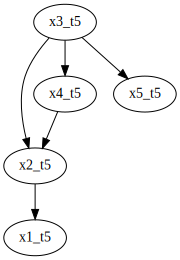

In [4]:
NUM_NODES     = 5
AFFINITY      = .5
MAX_LAG       = 5

dag = nx.DiGraph()
nodes = ['x%s_t%s' % (str(n+1), MAX_LAG) for n in range(NUM_NODES)]

edges = []
for edge in [i for i in list(permutations(nodes, 2))]:
    r = np.random.random()
    if r < AFFINITY:
        edges.append(edge)

dag.add_nodes_from(nodes)
dag.add_edges_from(edges)

while True:
    try:
        dag.remove_edges_from(nx.find_cycle(dag))
    except:
        break    
        
dot = graphviz.Digraph()
for node in dag.nodes:
    dot.node(node)
    
for a, b in dag.edges:
    dot.edge(a, b)
    
dot

# Linear Guassian Models: All Around

In [5]:
class CausalAssignmentModel:
    """
    Basically just a hack to allow me to provide information about the
    arguments of a dynamically generated function.
    """
    def __init__(self, model, parents, params=None, weights=None):
        self.model   = model
        self.parents = parents
        self.params  = params
        self.weights = weights
        
    def __call__(self, *args, **kwargs):
        #assert len(args) == 0
        if self.params is not None:
            params = self.params+(n_samples,)
            return self.model(*params)
        
        elif self.params is None:
            return self.model(**kwargs)

    def __repr__(self):
        return "CausalAssignmentModel({})".format(",".join(self.parents))
    
def _normal():
    return np.random.normal,0 , 1

def linear_model(parents, weights, offset=0, noise_scale=1):
    assert len(parents) == len(weights)
    assert len(parents) > 0    

    def model(**kwargs):
        n_samples = kwargs["n_samples"]
        a = np.array([kwargs[p] * w for p, w in zip(parents, weights)], dtype=np.float)
        a = np.sum(a, axis=0)
        a += np.random.normal(loc=offset, scale=noise_scale, size=n_samples)
        return a
    
    return CausalAssignmentModel(model, parents , weights=weights)

In [9]:
assignments = {}

for g in nx.isolates(dag):
    print("Isolates: %s" % g)
    m = _normal()
    assignments[g] = CausalAssignmentModel(m[0], [], m[1:])

for i in nx.topological_sort(dag):
    parents = [k for k in dag.predecessors(i)]
    print(i, parents)
    if len(parents) == 0:
        m = _normal()
        assignments[i] = CausalAssignmentModel(m[0], [], m[1:])
        
    elif len(parents) > 0:
        #print("Child: %s" % i)
        num_weights = len(parents)
        model = linear_model
        assignments[i] = model(parents, [np.random.random() for par in range(num_weights)])

        

x3_t5 []
x5_t5 ['x3_t5']
x4_t5 ['x3_t5']
x2_t5 ['x3_t5', 'x4_t5']
x1_t5 ['x2_t5']


# Generate Temporal Lags and Equations

In [10]:
TIME_AFFINITY=.03
print(TIME_AFFINITY)
print(MAX_LAG)

0.03
5


In [12]:
lagged_equations = []

for i in reversed(range(1,MAX_LAG-1)):
    lag_connections = []
    for current_node in dag.nodes:
        for lagged_node in dag.nodes:
            n = lagged_node.split('_')[0]
            r = np.random.random()
            if r < TIME_AFFINITY:
                edge = ('%s_t%s' % (n, i), current_node)
                lag_connections.append(edge)
    lagged_equations.append(lag_connections)
    
lagged_assignments = defaultdict(list)

for lag in lagged_equations:
    for e in lag:
        model = linear_model
        lagged_assignments[e[1]].append(e[0])

lagged_sem = {}

for n, parents in lagged_assignments.items():
    num_weights = len(parents)
    model = linear_model # np.random.choice(models)
    lagged_sem[n] = model(parents, [np.random.random() for par in range(num_weights)])

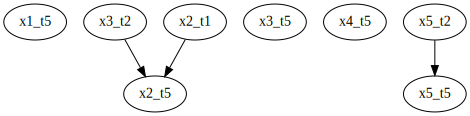

In [13]:
lag_dag = nx.DiGraph()

lag_dag.add_nodes_from(dag.nodes)

for lag in lagged_equations:
    for e in lag:
        lag_dag.add_node(e[0])
        lag_dag.add_edge(e[0], e[1])
        
dot = graphviz.Digraph()
for node in lag_dag.nodes:
    dot.node(node)
for a, b in lag_dag.edges:
    dot.edge(a, b)
    
dot

# Generate Time Series

In [14]:
samples = {}
n_samples = MAX_LAG-1

for node in nx.topological_sort(dag):
    c_model = assignments[node]

    parent_samples = {
        parent: samples[parent]
        for parent in c_model.parents
    }
    
    parent_samples["n_samples"] = n_samples
    #print(node, parent_samples)
    samples[node] = c_model(**parent_samples)
    
output = pd.DataFrame(samples)
output.columns = [x.split('_')[0] for x in output.columns]

new_samples = {}
n_samples = 1
rows = 100

for row in range(rows):
    for node in nx.topological_sort(dag):
        c_model = assignments[node]
        parent_samples = {
            parent: new_samples[parent]
            for parent in c_model.parents
        }

        parent_samples["n_samples"] = n_samples
        new_samples[node] = c_model(**parent_samples)
    
    for child, parents in lagged_sem.items():
        c_model  = parents
        exes     = [ex.split('_')[0] for ex in parents.parents]
        pos      = [ex.split('_')[1] for ex in parents.parents]
        values   = [output[loc[0]][int(loc[1].split('t')[1])] for loc in zip(exes, pos)]
        new_dict = dict(zip(parents.parents, values))
        new_dict["n_samples"] = n_samples
        new_samples[child] = c_model.model(**new_dict)
        
    append = pd.DataFrame(new_samples)
    append.columns = [x.split('_')[0] for x in append.columns]
    
    output = output.append(append, ignore_index=True)

output=output[MAX_LAG:]

# EDA

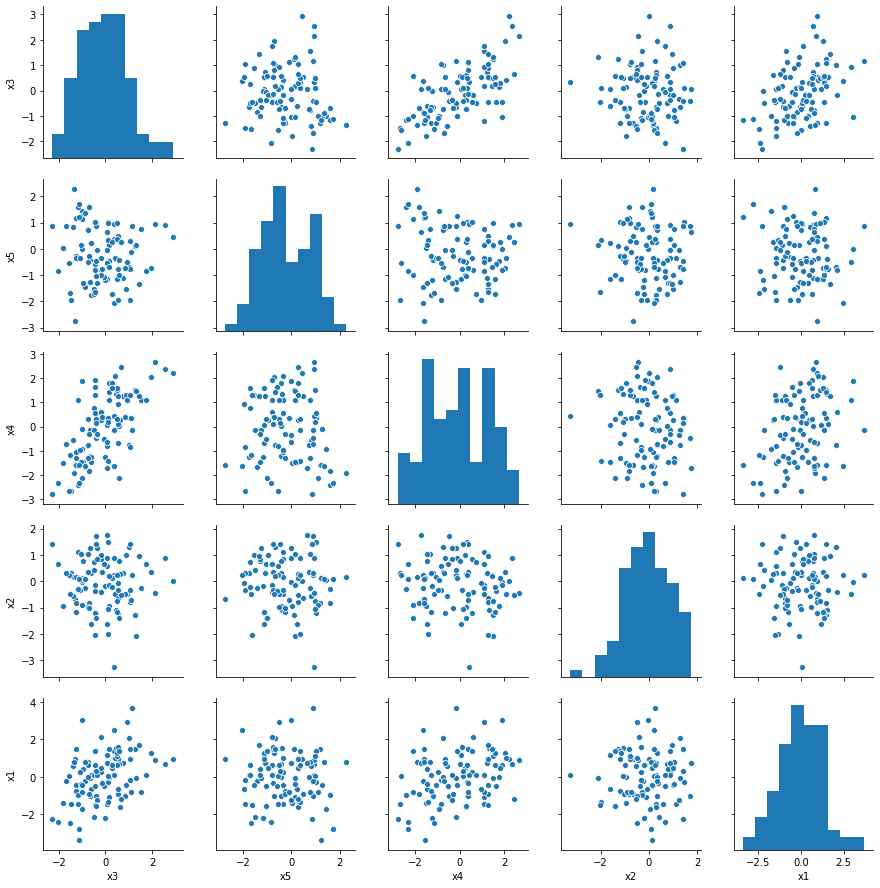

In [15]:
import seaborn as sns
# Create the default pairplot
sns.pairplot(output)

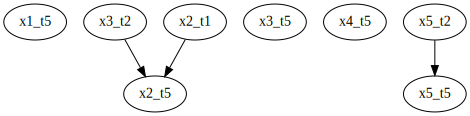

In [16]:
dot

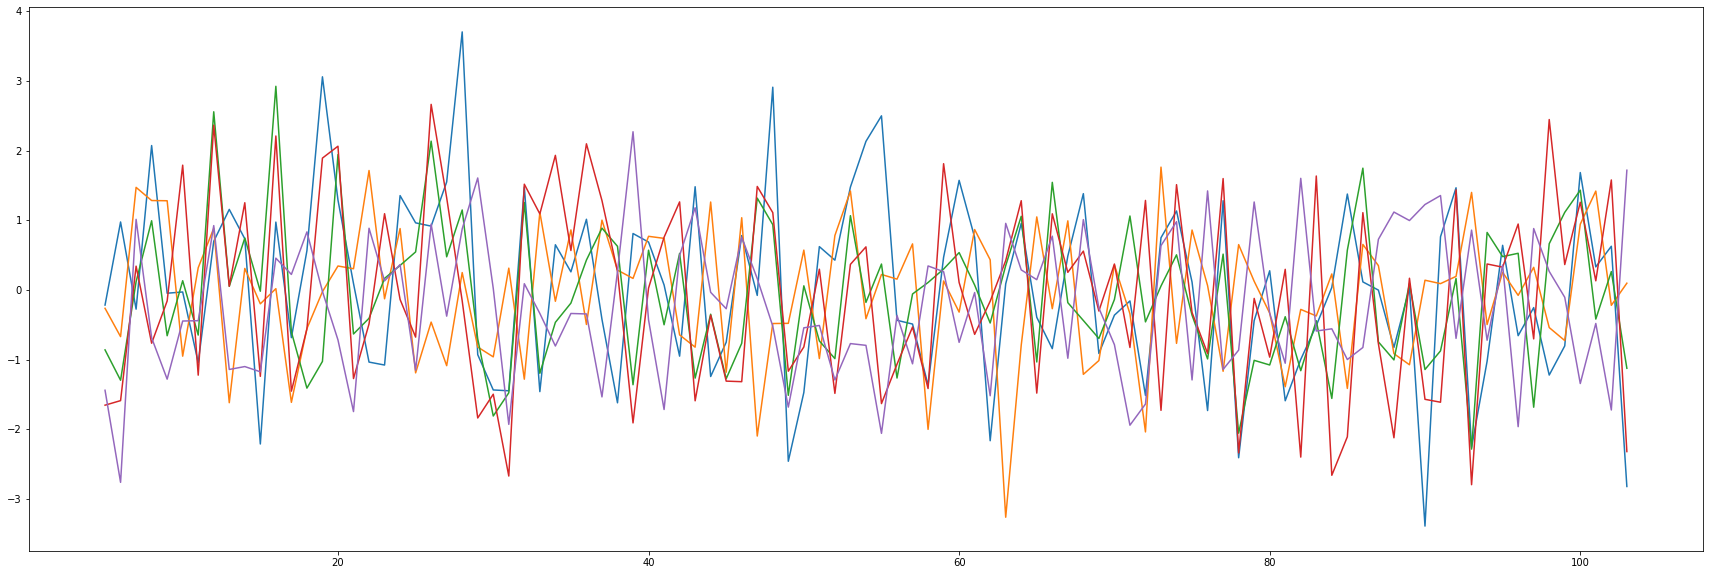

In [19]:
plt.rcParams["figure.figsize"] = [30,10]
plt.plot(output['x1'])
plt.plot(output['x2'])
plt.plot(output['x3'])
plt.plot(output['x4'])
plt.plot(output['x5'])